## Submission Instruction

1) First create a copy of this notebook in your drive and rename it to "DE_Lab1-firstname_lastname". (e.g. my copy would be DE_Lab1-sara_riazi)

2) When you are ready to submit (after running all cells). Downlowd the notebook file (File->Download->Download .ipynb), and submit it on Gradescope.

Note: Check your submission to make sure all cell outputs are present.

# Data Transforms - Rolling up NYC taxi data

Let's work with some raw data from the NYC yellow cabs.  The goal is to engineer a dataset that allows one to see how various usage statistics changed during Covid.  We'll focus on just May 2019 and May 2020 for the comparison.

You'll see that there are various issues we need to deal with before we can aggregate.

- NaN values
- Fixing improper datatypes
- Filtering data
- remove columns we don't actually need
- Create new metrics

After we deal with those issues we can roll up the data into daily bins and compare trends

**Note:** What we're learning here is the foundation of data transforms.  If this was part of an ETL you would write up the cleaning and transformations into several functions that then are executed after extracting the data but before loading elsewhere. You would do this on a schedule to where say each month when new taxi data is uploaded you would go and run this and then update the aggregated data.

**Note 2:** This is a pretty lengthy process.  There are lots of steps and times where we think we're done but then have to go back.  For example, we will think we did all our filtering, but then after making a feature realize we needed to do more filtering or filter that new column.  We do something to minimize the number of operations, but sometimes you catch something much later and just deal with it then.  If you were going to turn this into a function you would optimize the sequence of operations a bit more, but I didn't fully do that here so you can see what I mean.  


## Bringing in our data

In [1]:
# Bring in our libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Here I'm setting how many decimals are displayed for our floats.
# If you don't do this pandas will display like 8 decimals, which makes it significantly harder to make sense of when looking at it.
pd.set_option('float_format', '{:.2f}'.format)

In [2]:
# We'll pull the May 2019 data direct from the website...  This will take a second as it's on the larger side (700mb).
# The perk to using colab is you're downloading from Amazon to Google's storage, both of which are probably faster than your local connection!
# https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

rides_05_2019 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-05.parquet")


In [3]:
# And pull the May 2020
rides_05_2020 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-05.parquet")


In [4]:
# Let's first look and make sure it pulled in the right number of columns.
# Go and print the shape of both data frames in one cell
# Question 1: What is the shape of rides_05_2020?
#Answer:

print(rides_05_2019.shape)
print(rides_05_2020.shape)



(7598445, 19)
(348415, 19)


In [5]:
# So that looks good in that there are 19 in both.
# But ooph, over 7.5 million rides in May 2019 and not even 350,000 in May 2020

# Let's look at the column names to make sure they didn't change
# We also need to make sure the same as we're going to merge these two dataframes
print(rides_05_2019.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


In [6]:
# It's a bit awkward to look at both long lists, so why don't we just compare them?
# This is useful as sometimes companies will change data specifications mid year or year-to-year.
rides_05_2019.columns == rides_05_2020.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [7]:
# OK, so still not seeing any issues.
# Let's check datatypes of each and see if they differ.
# Print out the datatypes of both datasets

print(rides_05_2020.dtypes)
#Question 2: What is the data type of trip_distance?
#Answer: float64

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                      object
dtype: object


In [8]:
# So there may be some differences... let's again make it more clear with a comparison.
# Question 3: Fill in below for the comparison
rides_05_2019.dtypes == rides_05_2020.dtypes





VendorID                 True
tpep_pickup_datetime     True
tpep_dropoff_datetime    True
passenger_count          True
trip_distance            True
RatecodeID               True
store_and_fwd_flag       True
PULocationID             True
DOLocationID             True
payment_type             True
fare_amount              True
extra                    True
mta_tax                  True
tip_amount               True
tolls_amount             True
improvement_surcharge    True
total_amount             True
congestion_surcharge     True
airport_fee              True
dtype: bool


Let's go and explore VendorID in 2020.  We'll look at three different ways to dig into a column.

- `describe()` to check summary stats and see if anything is off
- `unique()` to see how many unique values are present
- `isna().sum()` to count up if and how many NaN values there are

In [9]:
# Using describe
rides_05_2020['VendorID'].describe()

count   348415.00
mean         1.63
std          0.48
min          1.00
25%          1.00
50%          2.00
75%          2.00
max          6.00
Name: VendorID, dtype: float64

We can see how many NaNs are there in each column:

In [10]:
# We can use isna().sum() to find the number of NaNs if one column
# How many NaNs in the passenger_count of the riders_05_2019?
rides_05_2019['passenger_count'].isna().sum()

np.int64(32770)

In [11]:
#Now look at the describe, what is the number of rows that has been used to calcuate the statistics?
rides_05_2020.describe()
# 17 rows


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,348415.00,348415,348415,289514.00,348415.00,289514.00,348415.00,348415.00,348415.00,348415.00,348415.00,348415.00,348415.00,348415.00,348415.00,348415.00,289514.00
mean,1.63,2020-05-16 21:47:01.946934,2020-05-16 22:00:32.603673,1.31,8.33,1.04,152.60,148.48,1.18,14.94,0.96,0.49,1.43,0.44,0.30,19.67,2.04
min,1.00,2008-12-31 23:05:47,2008-12-31 23:33:33,0.00,0.00,1.00,1.00,1.00,0.00,-240.00,-4.50,-0.50,-11.06,-13.75,-0.30,-244.30,-2.50
25%,1.00,2020-05-09 07:18:24,2020-05-09 07:34:38.500000,1.00,1.05,1.00,90.00,75.00,1.00,6.00,0.00,0.50,0.00,0.00,0.30,10.30,2.50
50%,2.00,2020-05-16 17:19:02,2020-05-16 17:31:49,1.00,1.99,1.00,143.00,143.00,1.00,9.00,0.00,0.50,0.01,0.00,0.30,13.80,2.50
75%,2.00,2020-05-24 16:28:31,2020-05-24 16:42:16.500000,1.00,4.25,1.00,231.00,230.00,2.00,16.00,2.50,0.50,2.45,0.00,0.30,21.30,2.50
max,6.00,2020-11-01 15:41:04,2020-11-01 15:57:02,9.00,297004.51,99.00,265.00,265.00,4.00,429496.72,65.53,3.30,442.18,200.00,0.30,429562.25,2.50
std,0.48,NaN,NaN,0.98,774.82,0.97,70.86,74.82,0.73,727.74,1.25,0.08,2.51,1.91,0.04,727.87,0.99


In [12]:
#How many not NaN rows we have for passenger count? and compare it non NaN rows for other columns such as VendorID
rides_05_2020.count()


VendorID                 348415
tpep_pickup_datetime     348415
tpep_dropoff_datetime    348415
passenger_count          289514
trip_distance            348415
RatecodeID               289514
store_and_fwd_flag       289514
PULocationID             348415
DOLocationID             348415
payment_type             348415
fare_amount              348415
extra                    348415
mta_tax                  348415
tip_amount               348415
tolls_amount             348415
improvement_surcharge    348415
total_amount             348415
congestion_surcharge     289514
airport_fee                   0
dtype: int64

OK, so it's clear we have missing data.  The NaN values in the column caused pandas to import the data as a float vs. an integer.  Let's just go do the same for another two columns and see what they look like.

In [13]:
# Another way to get a sense of what is happening here is to subset the data to show all of the lines where passenger_count is NaN to see if we can detect a pattern.
# This isn't an alternative to the previous steps, but rather additional information gathering to understand what the issue is.
rides_05_2020[rides_05_2020['passenger_count'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
289514,1,2020-05-01 00:02:28,2020-05-01 00:18:07,NaN,0.00,NaN,None,234,256,0,12.20,0.50,0.50,2.40,0.00,0.30,20.40,NaN,None
289515,2,2020-05-01 00:05:56,2020-05-01 00:45:05,NaN,23.92,NaN,None,159,91,0,70.66,0.00,0.00,0.00,6.12,0.30,77.08,NaN,None
289516,2,2020-05-01 00:03:28,2020-05-01 00:08:50,NaN,0.95,NaN,None,42,42,0,5.17,0.00,0.50,0.00,0.00,0.30,5.97,NaN,None
289517,2,2020-05-01 00:05:00,2020-05-01 00:20:00,NaN,5.60,NaN,None,137,24,0,18.36,0.00,0.50,0.00,0.00,0.30,21.66,NaN,None
289518,2,2020-05-01 00:45:00,2020-05-01 01:11:00,NaN,13.90,NaN,None,137,51,0,39.19,0.00,0.50,0.00,0.00,0.30,42.49,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348410,2,2020-05-31 23:49:40,2020-06-01 00:24:13,NaN,17.08,NaN,None,202,89,0,41.99,0.00,0.50,0.00,6.12,0.30,51.41,NaN,None
348411,2,2020-05-31 23:05:22,2020-05-31 23:31:21,NaN,15.09,NaN,None,137,218,0,39.56,0.00,0.50,0.00,6.12,0.30,48.98,NaN,None
348412,2,2020-05-31 23:12:51,2020-05-31 23:27:52,NaN,2.36,NaN,None,82,56,0,6.73,0.00,0.50,0.00,0.00,0.30,7.53,NaN,None
348413,2,2020-05-31 23:32:00,2020-05-31 23:38:00,NaN,1.14,NaN,None,137,162,0,5.93,0.00,0.50,0.00,0.00,0.30,9.23,NaN,None


What did this tell us?

- We have the same number of NaN values in the columns that imported as different datatypes across the years. This suggests some sort of data entry issues/errors in those rows and that the NA/NaNs are not randomly scattered across different rows. So, for some reason 50k+ rows were entered with some missing data.

- Our `fare_amount` column, and seemingly all of the columns except for 'passenger_count', 'RatecodeID', 'congestion_surcharge', and 'airport_fee' have no missing data. Those entry issues were likely isolated to just those columns.  You'd want to do more checking (e.g. sytematically looking for NAs in each column, making sure all of the NAs are on the same rows, etc.), but we're not going to do that here.

- We have values that are extreme/not based in reality in our fare_amount column (e.g. -240.00), which is an issue. And we're going to want to do a `describe` on the whole dataset. But let's deal with our NaN values first.



## Dropping NaNs, bringing dataframes together

We know we need to deal with extreme values, but such extreme values might also be present in 2020.  So best to wait until we bring the data together to filter those off rather than do them on both datasets.  *But* we will want to convert our improper 2019 datatypes first and drop NA values before joining.

### Checking and Dropping NaNs

In [14]:
# Now drop all the NA values.
# Easy just by adding .dropna() function at the end of the dataset you want to drop from

rides_05_2020_dropped = rides_05_2020.dropna()
print(rides_05_2020_dropped.shape)



(0, 19)


It looks like we lost all of the rows! Why?
Let's look at the NaNs in the original dataframe again

In [15]:
rides_05_2020.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count           58901
trip_distance                 0
RatecodeID                58901
store_and_fwd_flag        58901
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge      58901
airport_fee              348415
dtype: int64

Do you see the problem? The column airport_fee does not have value for any row which causes dropna to drop all rows. To avoid that we have to first drop that column!

In [16]:
rides_05_2020 = rides_05_2020.drop(columns=['airport_fee'])
rides_05_2020.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          58901
trip_distance                0
RatecodeID               58901
store_and_fwd_flag       58901
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     58901
dtype: int64

In [17]:
# Now we can drop the NaNs
# Let's store the existing number of rows in the 2020 data before we drop
rows_2020_predrop = rides_05_2020.shape[0]

rides_05_2020 = rides_05_2020.dropna()
# Do an internal check by getting the number of rides now and calculating the difference
rows_2020_postdrop = rides_05_2020.shape[0]
rows_2020_predrop - rows_2020_postdrop

58901

Great!  So dropping those rows dropped the number of NaN values we were seeing in single columns.  

If we were seeing a number greater than that it would suggest that there were NA's in other columns but in different positions. Luckily we don't have to worry about that.  


In [18]:
#Lets see if have any NaN remained
rides_05_2020.isna().sum()


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

In [19]:
#Question 4: Do the same for rides_05_2019 but you have to check and make sure the data have the problems
rides_05_2019.isna().sum()
rides_05_2019 = rides_05_2019.drop(columns=['airport_fee'])
rides_05_2019.isna().sum()
rows_2019_predrop = rides_05_2019.shape[0]
rides_05_2019 = rides_05_2019.dropna()
rows_2019_postdrop = rides_05_2019.shape[0]
rows_2019_predrop - rows_2019_postdrop      



32770

### Concatenating our data frames

Yay!  OK, let's bring our data together finally

The `concat()` function in pandas allows you to join one dataframe to the bottom of another. Note that column number and names must match (which we know they do because we checked earlier). And same with datatypes.  

**Def - concatenate:** To join or link together

In [20]:
# Call our full set of data 'rides'
rides = pd.concat([rides_05_2019, rides_05_2020])

In [21]:
# Now check the shape and make sure it makes sense.  Are the number of rows equal to the sum of rows in the individual data frames?
#Question 5: What is the shape of rides (after dropping NaNs and concatenating rides_05_2019 and rides_05_2020)?
#Answer:

print(rides.shape)

(7855189, 18)


## Making useful

We did the above in a really manual way.  That's fine for a first pass, but ideally what you would do is build in checks that took in the data, looked for NA's, and if there were them dropped and converted datatypes.  That's a bit much at this point, but I just want to highlight that the goal is to automate this process so it's done on a regular basis without intervention.  By the end of the class we'll be doing a good bit of that!

For now, we have our dataset of May rides in 2019 and 2020.  Let's now make it useful. To do so we want to do the following:

- Drop columns we don't need
- Filter out data that don't make sense
- Convert columns to datetimes
- Get metrics that are of interest.  Specifically, let's get calculate the average speed, average passengers, and average tip so that we can compare these between years.  
- To get the above we'll need to aggregate our data, but before that we'll need to create new columns.  

### Dropping columns
Let's select only the columns we need.

To do this you can just put a list of column names inside of `rides[]` and then assign back to your dataframe.  

You can also drop columns individually with `df.drop(columns = ['col_to_drop'])`

In [22]:
rides = rides[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount']]

Let's take another look at our simplied data and see if we can detect other problems

In [23]:
rides.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
count,7855189,7855189,7855189.00,7855189.00,7855189.00,7855189.00
mean,2019-05-29 14:23:27.205906,2019-05-29 14:41:38.915890,1.56,3.02,13.41,2.23
min,2001-01-01 00:09:39,2001-01-01 06:39:54,0.00,0.00,-375.00,-82.60
25%,2019-05-08 17:37:59,2019-05-08 17:58:10,1.00,1.00,6.50,0.00
50%,2019-05-16 12:20:23,2019-05-16 12:42:41,1.00,1.66,9.50,1.92
75%,2019-05-24 07:44:09,2019-05-24 08:00:20,2.00,3.10,15.00,2.96
max,2020-11-01 15:41:04,2020-11-01 15:57:02,9.00,10973.55,429496.72,444.00
std,NaN,NaN,1.21,5.55,153.75,2.83


## Filtering out bad data



- Our min passenger count is zero and our min trip distance is also zero.  We should select only rows where there is at least one passenger. We'll also want to deal with the 0s in distance, but setting an appropriate minimum cutoff is harder than with setting a min of 1 passenger.
  
  \* In reality, you'd want to check whether rides without passengers actually occur in some cases and think about whether these cases are relevant to the analyses the end user would want to be doing

- Our min fare and tip are also negative.  Let's set min fare to be at least $2.50 (the initial charge for NYC cabs https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page).

- Our max trip distance is 10000+ miles!  And the max fare amount is over $400,000.  Obviously wrong, so we want to filter those out as well. However, there is the same issue here as with setting an objective min distance.

  A good way of dealing with these is first handling the obvious cases with clear cutoffs (i.e. passengers > 0 and min fare > 2.50) and then checking to see if the other problem cases persist. Sometimes a lot of problematic data are part of the same row, so eliminating some rows based on very reasonable assumptions avoid having to make potenitally questionable assumptions about other data.

In [24]:
# Filtering out bad values is pretty easy.
# A basic version is like this:
rides = rides[rides['trip_distance'] >= 0.25]

# But you can string them together and knock out everything in one go
rides = rides[(rides['passenger_count'] >= 1) &
              (rides['fare_amount'] >= 2.5)]
rides.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
count,7566307,7566307,7566307.00,7566307.00,7566307.00,7566307.00
mean,2019-05-29 00:07:22.066664,2019-05-29 00:25:51.325981,1.59,3.07,13.33,2.24
min,2001-01-01 00:09:39,2001-01-01 06:39:54,1.00,0.25,2.50,0.00
25%,2019-05-08 17:23:59,2019-05-08 17:45:18,1.00,1.00,6.50,0.00
50%,2019-05-16 11:47:44,2019-05-16 12:09:51,1.00,1.70,9.50,1.95
75%,2019-05-24 06:19:06,2019-05-24 06:39:40,2.00,3.12,15.00,3.00
max,2020-11-01 15:41:04,2020-11-01 15:57:02,9.00,10973.55,4016.50,444.00
std,NaN,NaN,1.21,5.61,11.81,2.75


In [25]:
# Unfortunately, that didn't solve all of our issues. We still have unreasonably high distances and fare amounts.
# At least we have dealt with the $430k fare, but we still have a fare > 10k miles
# So, let's look at that datapoint and see whether it seems reasonable or not
rides[rides['trip_distance'] > 10000]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
29008,2020-05-04 17:26:27,2020-05-04 18:40:37,1.00,10973.55,15.99,0.00


In [26]:
# Looking at it, the fare amount is $15.99, which seems inexpensive for a 10k mile ride! In all likelihood, there was a data entry error in the distance, so we can remove that data point
rides = rides[rides['trip_distance'] < 10000]
rides.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
count,7566306,7566306,7566306.00,7566306.00,7566306.00,7566306.00
mean,2019-05-29 00:07:18.164529,2019-05-29 00:25:47.423404,1.59,3.07,13.33,2.24
min,2001-01-01 00:09:39,2001-01-01 06:39:54,1.00,0.25,2.50,0.00
25%,2019-05-08 17:23:59,2019-05-08 17:45:18,1.00,1.00,6.50,0.00
50%,2019-05-16 11:47:44,2019-05-16 12:09:51,1.00,1.70,9.50,1.95
75%,2019-05-24 06:19:05,2019-05-24 06:39:39.500000,2.00,3.12,15.00,3.00
max,2020-11-01 15:41:04,2020-11-01 15:57:02,9.00,401.40,4016.50,444.00
std,NaN,NaN,1.21,3.94,11.81,2.75


In [27]:
# Now things are starting to look more realistic. There's a 400 mile ride, but also a $4000 fare (which are likely the same ride) and that *could* happen
# Let's look at those data points:
rides[rides['trip_distance'] > 400]


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
3731018,2019-05-15 17:22:11,2019-05-15 17:33:40,1.00,401.40,8.50,1.55


The fare amount does not sense, so we have to remove it!

In [28]:
rides = rides[rides['trip_distance'] < 400]

In [29]:
#How about the fare_amount larger than 4000?
#If the trip_distance does not make sense for the fare_amount, we should remove it.
#Question 5: What is the trip_distance of the ride with the fare_amount larger than 4000$?
#Answer:

rides[rides['fare_amount'] > 4000]
#  3.8 miles

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
3808994,2019-05-15 22:20:01,2019-05-15 22:42:23,1.00,3.80,4016.50,0.00


In [30]:
#Question 6: Remove all the rows with far_amount larger than 4000
rides = rides[rides['fare_amount'] < 4000]
rides.describe()



,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
count,7566304,7566304,7566304.00,7566304.00,7566304.00,7566304.00
mean,2019-05-29 00:07:18.465490,2019-05-29 00:25:47.724388,1.59,3.07,13.33,2.24
min,2001-01-01 00:09:39,2001-01-01 06:39:54,1.00,0.25,2.50,0.00
25%,2019-05-08 17:23:58.750000,2019-05-08 17:45:18,1.00,1.00,6.50,0.00
50%,2019-05-16 11:47:44,2019-05-16 12:09:51,1.00,1.70,9.50,1.95
75%,2019-05-24 06:19:05.500000,2019-05-24 06:39:40,2.00,3.12,15.00,3.00
max,2020-11-01 15:41:04,2020-11-01 15:57:02,9.00,305.10,819.50,444.00
std,NaN,NaN,1.21,3.94,11.72,2.75


Let's take another look at our data

In [31]:
rides.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
count,7566304,7566304,7566304.00,7566304.00,7566304.00,7566304.00
mean,2019-05-29 00:07:18.465490,2019-05-29 00:25:47.724388,1.59,3.07,13.33,2.24
min,2001-01-01 00:09:39,2001-01-01 06:39:54,1.00,0.25,2.50,0.00
25%,2019-05-08 17:23:58.750000,2019-05-08 17:45:18,1.00,1.00,6.50,0.00
50%,2019-05-16 11:47:44,2019-05-16 12:09:51,1.00,1.70,9.50,1.95
75%,2019-05-24 06:19:05.500000,2019-05-24 06:39:40,2.00,3.12,15.00,3.00
max,2020-11-01 15:41:04,2020-11-01 15:57:02,9.00,305.10,819.50,444.00
std,NaN,NaN,1.21,3.94,11.72,2.75


In [32]:
# Now the max distance and fares are ~300 and 800, so let's check again to see if that's the same entry
rides[rides['trip_distance'] > 300]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
133229,2020-05-16 12:19:05,2020-05-16 18:54:20,2.00,305.10,801.50,173.80


In [33]:
# Here it does seem to be a legitimate entry, so we'll leave it.
# As a sort of 'gut check' to make sure we're not missing any issues with distances below 300 that *are* problematic, we can do this:
rides[rides['trip_distance'] > 100]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount
481992,2019-05-02 20:48:32,2019-05-03 00:22:41,1.00,225.30,350.00,0.00
1137317,2019-05-05 07:48:25,2019-05-05 10:20:50,1.00,112.30,450.00,0.00
3099015,2019-05-13 07:45:54,2019-05-13 09:19:46,5.00,103.33,250.00,0.00
3534698,2019-05-14 20:19:26,2019-05-15 01:16:22,2.00,263.21,450.05,0.00
3947992,2019-05-16 13:22:29,2019-05-16 15:55:10,3.00,108.21,300.00,0.00
4699693,2019-05-19 11:04:31,2019-05-19 13:11:04,1.00,123.57,400.00,25.00
4839912,2019-05-19 23:35:50,2019-05-20 03:54:48,1.00,149.50,394.50,82.00
4934907,2019-05-20 12:49:36,2019-05-20 15:25:05,2.00,109.34,508.00,0.00
5004257,2019-05-20 16:57:34,2019-05-20 19:59:35,1.00,112.04,298.50,0.00
6125703,2019-05-25 09:18:22,2019-05-25 11:16:37,1.00,104.48,200.00,24.55


A quick scan of the data shows high fares associated with long distances, which suggest the data are *probably* ok.

In reality, and when building a real pipeline to deal extracting and cleaning these more automatically, we'd probably use an algorithm comparing distance and fare for each entry (using the offical rates as an estimated min) as a way of removing data entry errors of this sort. But going through these manually as a first step allows you to understand the data and the types of errors that might occur and ultimately will help you figure out the best way of doing this automatically.

Generally, as a DE you're trying to balance 1) having accurate data with 2) removing too much data, 3) how much time you spend cleaning these up, and 4) what the end user needs. In all cases, the output produced will be a compromise along all of these axes.

### Convert to datetime and make triptime column

Now that we have only realistic values we can start making our columns


In [34]:
# Lets Check the datatype of tpep_pickup_datetime and tpep_dropoff_datetime to see if they  datetimes
# Check your datatypes
rides.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
tip_amount                      float64
dtype: object

It looks like we are OK with datatypes

One issue that will frequently arise are dates that are wrong.  These data should just be in May of 2019 and 2020.  But I bet if we ask what the min pickup date is we'll get something lower.  And I'm sure the max is higher.  So we need to filter out those values!

**Note:** We're going to want to filter out two months.  This means we want to filter dates that are greater than May 1st, 2019 **and** less than May 31st, 2019 **OR** greater than May 1st, 2020 **and** less than May 31st, 2020.  The or operator is simply a pipe `|`.

In [35]:
# Check
print(rides['tpep_pickup_datetime'].min())
print(rides['tpep_pickup_datetime'].max())

2001-01-01 00:09:39
2020-11-01 15:41:04


In [36]:
# Clearly out of range. So let's filter again
rides = rides[(rides['tpep_pickup_datetime'] >= '2019-05-01 00:00:00') &
               (rides['tpep_pickup_datetime'] <= '2019-05-31 23:59:59') | # note me using '|' for OR.
               (rides['tpep_pickup_datetime'] >= '2020-05-01 00:00:00') &
               (rides['tpep_pickup_datetime'] <= '2020-05-31 23:59:59')]
print(rides['tpep_pickup_datetime'].min())
print(rides['tpep_pickup_datetime'].max())

2019-05-01 00:00:00
2020-05-31 23:59:56


In [37]:
# Do the same for the 'tpep_dropoff_datetime'
print(rides['tpep_dropoff_datetime'].min())
print(rides['tpep_dropoff_datetime'].max())

#Question 7: What is the maximum dropoff time after cleaning?
#Answer: 2020-06-01 16:56:14

2018-09-13 10:38:20
2020-06-01 16:56:14


Datetime conversion can get a bit tricky.  Datetimes get stored in lots of different ways and the methods for each way can differ a bit.  [The pandas documentation is a good guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html).

Here we're going to subtract the dropoff time from the pickup time into a new column called `trip_time`.

That operation will give you a datatype called `timedelta64[ns]` meaning it's a datatype that's specific to time differences and that it's calculating in nanoseconds (ns).  So we also need to convert that to seconds using our trusty `astype()`.  Inside the `astype()` you'll tell it what you wanted to convert it to.  In this case seconds, the datatype of which is `timedelta64[s]`.

In [38]:
# Quesion 7:
# First make a new column called trip_time.  That should be the dropoff minus the pickup time

rides['trip_time'] = rides['tpep_dropoff_datetime'] - rides['tpep_pickup_datetime']

# Check the new column.  Note the dtype
print(rides['trip_time'].dtype)

timedelta64[us]


We clearly have to do one last filter to fix the bad trip times. Normally we'd go through the same steps as above of checking the data bit by bit, but to save time here we'll assume that a realistic trip is at least two minutes and less than say 120 minutes (this will likely remove more data than necessary, but that's ok for this example)

In [39]:
# It never ends!
# Do one a filter where you filter your dataframe down such that it...
# Only has trip times greater than 2 and less than / equal to 120
#to compare times use pd.Timesdelta for example : rides['trip_time'] > pd.Timedelta(minutes=2))

rides = rides[(rides['trip_time'] >= pd.Timedelta(minutes=2)) & (rides['trip_time'] <= pd.Timedelta(minutes=120))]
# Verify
rides.describe()

#Question 8: What is average (mean) trip_time after filtering?
#Answer: 7462544

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,trip_time
count,7462544,7462544,7462544.00,7462544.00,7462544.00,7462544.00,7462544
mean,2019-05-28 19:59:43.166394,2019-05-28 20:14:47.886121,1.59,3.09,13.39,2.25,0 days 00:15:04.719728
min,2019-05-01 00:00:00,2019-05-01 00:02:57,1.00,0.25,2.50,0.00,0 days 00:02:00
25%,2019-05-08 17:20:32,2019-05-08 17:39:30.750000,1.00,1.01,6.50,0.00,0 days 00:07:00
50%,2019-05-16 11:37:58.500000,2019-05-16 11:57:20,1.00,1.70,9.50,1.96,0 days 00:11:34
75%,2019-05-24 04:53:31.500000,2019-05-24 05:07:13,2.00,3.15,15.00,3.00,0 days 00:18:56
max,2020-05-31 23:59:56,2020-06-01 00:26:13,9.00,116.57,541.50,444.00,0 days 02:00:00
std,NaN,NaN,1.21,3.92,11.56,2.74,0 days 00:12:14.408877


### Making other metrics

Let's now make our metrics.  The exact metrics depend on the use case of the dataset.  Here we want to see how rider properties change, so we'll look at things like overall ridership, usage, as well as how they behave via tipping. We'll make the following:

- A speed column.  We'll divide distance by time.  Will speed increase during Covid?  
- A tip per time column.  We'll see if people tip more during Covid.
- We'll also make a binary column if they tipped that we'll count up later to figure out the percentage of people tipping.

Note, it's important to think about the order in which you're doing these tasks.  For example, if we didn't filter out those negative or zero distance trips, it would cause problems making these columns

In [40]:
# Speed column first.
# This is relatively simple.
# The only tricky thing is that our time is in minutes but we'll want speed in miles per hour

rides['trip_speed'] = rides['trip_distance'] / (rides['trip_time'].dt.total_seconds() / 3600)
rides['trip_speed']

3         8.03
4        11.36
7        15.60
8        14.10
9        18.00
          ... 
289505   20.89
289509   25.51
289510   17.66
289511    9.50
289512   19.86
Name: trip_speed, Length: 7462544, dtype: float64

Now let's make a feature of how many dollars are tipped per mile traveled.  Are people being more or less generous with tipping?

In [41]:
# Question 9: Make a column 'tip_per_distance' where you divide the tip amount by trip distance
rides['tip_per_distance'] = rides['tip_amount'] / rides['trip_distance']


OK, now let's look at some summary stats again!

In [42]:
#Question 10: What is the maximum tip per distance? (Hint: use describe)
#Answer: 492.54
rides['tip_per_distance'].describe()

count   7462544.00
mean          1.10
std           1.22
min           0.00
25%           0.00
50%           0.98
75%           1.68
max         492.54
Name: tip_per_distance, dtype: float64

Clearly we need to filter some more. Here again, we're going to make some very rough assumptions that normally we'd need to dig into the data more instead.

However, for this exercise we'll assume that trip speed should be less than 75 mph and tip per distance less than $10

In [43]:
# Filter data frame so that trip_speed is less than 75 and tip per distance less than 10
rides = rides[(rides['trip_speed'] <= 75) &
              (rides['tip_per_distance'] <= 10)]
rides.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,trip_time,trip_speed,tip_per_distance
count,7458673,7458673,7458673.00,7458673.00,7458673.00,7458673.00,7458673,7458673.00,7458673.00
mean,2019-05-28 19:48:00.413231,2019-05-28 20:03:05.357254,1.59,3.09,13.38,2.25,0 days 00:15:04.944023,11.32,1.09
min,2019-05-01 00:00:00,2019-05-01 00:02:57,1.00,0.25,2.50,0.00,0 days 00:02:00,0.18,0.00
25%,2019-05-08 17:20:15,2019-05-08 17:39:10,1.00,1.01,6.50,0.00,0 days 00:07:00,7.28,0.00
50%,2019-05-16 11:37:25,2019-05-16 11:56:54,1.00,1.70,9.50,1.96,0 days 00:11:34,9.89,0.98
75%,2019-05-24 04:49:49,2019-05-24 05:03:53,2.00,3.15,15.00,3.00,0 days 00:18:56,13.57,1.68
max,2020-05-31 23:59:56,2020-06-01 00:26:13,9.00,116.57,528.00,176.00,0 days 02:00:00,74.21,10.00
std,NaN,NaN,1.21,3.92,11.54,2.66,0 days 00:12:14.470187,6.12,1.06


And finally let's just make a binary of if they tipped or not.

Remember `np.where()` is nice for these ifelse type of statements.  The first argument is the condition where you're comparing something.  The second for what to do if that condition was met.  The last is if that condition isn't met.  

In [44]:
# If tip_amount is greater than zero then 1 (they tipped).
# if it's not, then 0 (they didn't tip).
rides['tipped'] = np.where(rides['tip_amount'] > 0, 1, 0)

## Aggregating

Wow, so a lot of wrangling data to get it into shape.  Again, our goal would be to make this be able to work with a dashboard or build a report to answer business questions.  As a DE your job would be to build the pipeline that does all these transforms and then upload it somewhere.  

So now lets go and aggregate our data into daily averages as that's likely what they'd be interested in.  

There are two main parts to aggregating used here.

- The `groupby()`: This is saying what column you want to colapse down into groups and calculate summary stats for.  In this case I'm calling the pickup time, then using `.dt` which allows us to access  properties of the datetime column. That's followed up by `.date` which means we want to group by individual dates.  You could do other levels if you wanted such as second, hour, or even quarter.

- The `.agg()`: This is saying how you want to aggregate within the groups (in this case individual dates).  Inside `.agg()` you provide a dictionary where the key is the column in the original data you want to work with and then the value is a list of math you want to do on that column.  So if you had just `{'passenger_count': ['mean']}` you'd be asking for it to calculate the mean passenger count for each distinct group (in this case days).

This is a semi-complex groupby given we want a lot of things, but I think you can handle it!  I encourage you to go and play with it a bit to see what different levels you can aggregate by and what types of functions you can apply.


In [45]:
rides_daily = rides.groupby(rides['tpep_pickup_datetime'].dt.date).agg({'passenger_count': ['mean'],
                                                                        'trip_distance': ['mean'],
                                                                        'trip_speed': ['mean'],
                                                                        'tip_amount': ['mean'],
                                                                        'tip_per_distance': ['mean'],
                                                                        'fare_amount':['count'],
                                                                        'tipped': ['sum']})
rides_daily # look at it!

,passenger_count,trip_distance,trip_speed,tip_amount,tip_per_distance,fare_amount,tipped
,mean,mean,mean,mean,mean,count,sum
tpep_pickup_datetime,,,,,,,
2019-05-01,1.57,3.01,10.72,2.36,1.18,256814,187912
2019-05-02,1.58,3.03,10.40,2.37,1.17,264613,191742
2019-05-03,1.60,3.04,10.70,2.29,1.12,262469,186155
2019-05-04,1.68,2.87,11.67,2.00,1.01,253037,172133
2019-05-05,1.65,3.31,12.97,2.16,0.98,224079,153476
...,...,...,...,...,...,...,...
2020-05-27,1.41,2.81,14.74,1.64,0.83,11198,6483
2020-05-28,1.37,2.75,14.69,1.68,0.87,10875,6461


Cool!  So we have 62 rows as we'd expect for two different May months.

**Note** this groupby took the pickup time and turned it into our index!

The only issue is now we have an annoying 'multi index' for the column names.  Essentially to access one we'd have to do something like `rides_daily['passenger_count']['mean']`.  That's annoying, so let's rename quick.

Renaming columns can be done if you call `.columns` on the left of the `=`.  What this does is then access the column names of the dataframe and replaces them with the list of new names that are right of the `=`.

In [46]:
rides_daily.columns = ['mean_pass', 'mean_dist', 'mean_speed', 'mean_tip', 'mean_tip_dist', 'total_rides', 'number_tipped']
rides_daily

,mean_pass,mean_dist,mean_speed,mean_tip,mean_tip_dist,total_rides,number_tipped
tpep_pickup_datetime,,,,,,,
2019-05-01,1.57,3.01,10.72,2.36,1.18,256814,187912
2019-05-02,1.58,3.03,10.40,2.37,1.17,264613,191742
2019-05-03,1.60,3.04,10.70,2.29,1.12,262469,186155
2019-05-04,1.68,2.87,11.67,2.00,1.01,253037,172133
2019-05-05,1.65,3.31,12.97,2.16,0.98,224079,153476
...,...,...,...,...,...,...,...
2020-05-27,1.41,2.81,14.74,1.64,0.83,11198,6483
2020-05-28,1.37,2.75,14.69,1.68,0.87,10875,6461
2020-05-29,1.41,2.81,14.83,1.70,0.87,12126,7202


Now that we have our grouped data we want to make one last feature of the percent of riders that tipped.  Given we counted up a binary column in our `.agg`, we can just divide the `number_tipped` column by the `total_rides` column and multiply by 100 to get the units into percentages.

In [47]:
# Make percent column.
rides_daily['percent_tipped'] = rides_daily['number_tipped']/rides_daily['total_rides']*100
rides_daily

,mean_pass,mean_dist,mean_speed,mean_tip,mean_tip_dist,total_rides,number_tipped,percent_tipped
tpep_pickup_datetime,,,,,,,,
2019-05-01,1.57,3.01,10.72,2.36,1.18,256814,187912,73.17
2019-05-02,1.58,3.03,10.40,2.37,1.17,264613,191742,72.46
2019-05-03,1.60,3.04,10.70,2.29,1.12,262469,186155,70.92
2019-05-04,1.68,2.87,11.67,2.00,1.01,253037,172133,68.03
2019-05-05,1.65,3.31,12.97,2.16,0.98,224079,153476,68.49
...,...,...,...,...,...,...,...,...
2020-05-27,1.41,2.81,14.74,1.64,0.83,11198,6483,57.89
2020-05-28,1.37,2.75,14.69,1.68,0.87,10875,6461,59.41
2020-05-29,1.41,2.81,14.83,1.70,0.87,12126,7202,59.39


In [48]:
#Question 11: What is the percent_tipped for 2020-05-30?
#Answer: 59.63


## Graphing and making some inference

Phew!  So, lots of data processing to get to this point.  Let's make a visualization like someone would who was running operations.  For example, how does speed change over day-to-day for both months.

since we'll want to graph both lines on one plot over the month, we'll need to first  make a new column for day of the week, and then split our data into 2019 and 2020

OK, let's make our day column.  Remember that when we did our aggregation our time value became the index.  So we need to call the index with `rides_daily.index` inside of `to_datetime()`.  As it's a datetime we can just ask it for the actual day using `.day`

In [49]:
# Make day column.
# This is saying 'pandas, convert our index to a datetime and extract the day.
rides_daily['day'] = pd.to_datetime(rides_daily.index).day
rides_daily

,mean_pass,mean_dist,mean_speed,mean_tip,mean_tip_dist,total_rides,number_tipped,percent_tipped,day
tpep_pickup_datetime,,,,,,,,,
2019-05-01,1.57,3.01,10.72,2.36,1.18,256814,187912,73.17,1
2019-05-02,1.58,3.03,10.40,2.37,1.17,264613,191742,72.46,2
2019-05-03,1.60,3.04,10.70,2.29,1.12,262469,186155,70.92,3
2019-05-04,1.68,2.87,11.67,2.00,1.01,253037,172133,68.03,4
2019-05-05,1.65,3.31,12.97,2.16,0.98,224079,153476,68.49,5
...,...,...,...,...,...,...,...,...,...
2020-05-27,1.41,2.81,14.74,1.64,0.83,11198,6483,57.89,27
2020-05-28,1.37,2.75,14.69,1.68,0.87,10875,6461,59.41,28
2020-05-29,1.41,2.81,14.83,1.70,0.87,12126,7202,59.39,29


Now we'll slice into years using our index

This is pretty straightforward in that we're going to use `.loc[]` to slice by the index like we did last week. So the format is:
`new_df = df.loc[start_date : end_date]`

The only tricky part is that you can't just tell it a time inside the slice.  You need to wrap `pd.to_datetime().date()` around the start and end dates so python knows they're datetimes!

In [50]:
# OK let's do it!
rides_daily_2019 = rides_daily.loc[pd.to_datetime('2019-05-01').date():pd.to_datetime('2019-05-31').date()]
rides_daily_2020 = rides_daily.loc[pd.to_datetime('2020-05-01').date():pd.to_datetime('2020-05-31').date()]

# now check
rides_daily_2020.head()

,mean_pass,mean_dist,mean_speed,mean_tip,mean_tip_dist,total_rides,number_tipped,percent_tipped,day
tpep_pickup_datetime,,,,,,,,,
2020-05-01,1.34,2.75,15.44,1.50,0.80,8744,4675,53.47,1
2020-05-02,1.37,2.80,15.99,1.46,0.77,6417,3448,53.73,2
2020-05-03,1.40,2.98,16.84,1.55,0.78,4782,2618,54.75,3
2020-05-04,1.36,2.73,15.61,1.49,0.79,7882,4204,53.34,4
2020-05-05,1.38,2.77,15.45,1.52,0.82,7945,4407,55.47,5


OK, let's first see how trip distance changed in response to Covid

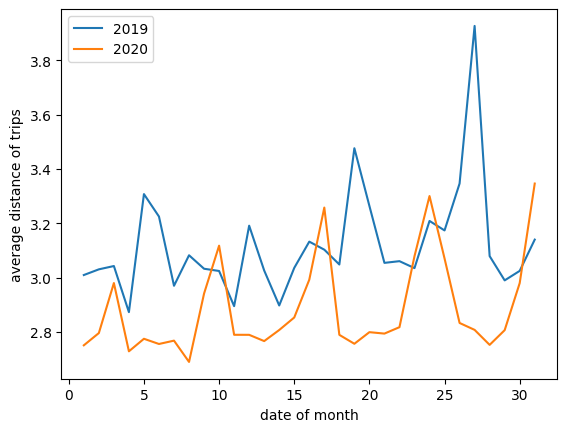

In [51]:
plt.plot(rides_daily_2019['day'], rides_daily_2019['mean_dist'], label = 2019)
plt.plot(rides_daily_2020['day'], rides_daily_2020['mean_dist'], label = 2020)
plt.xlabel('date of month')
plt.ylabel('average distance of trips')
plt.legend()
plt.show()

Interestingly, it seems like people were making shorter trips during covid. We can imagine several plausible reasons for this, such as people simply moving around the city less and staying within their neighborhoods more, or simply not being comfortable in cab for longer periods of time to limit their risk of infection.

You can see there are a lot of spikes that don't align, but that's just because the weekends fall on different dates.

How does speed change?



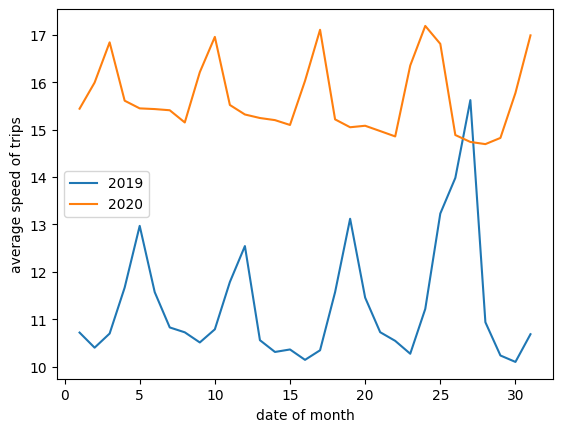

In [52]:
# Question 12: Make a plot looking at average speed of trips over the dates of both years.
plt.plot(rides_daily_2019['day'], rides_daily_2019['mean_speed'], label = 2019)
plt.plot(rides_daily_2020['day'], rides_daily_2020['mean_speed'], label = 2020)
plt.xlabel('date of month')
plt.ylabel('average speed of trips')
plt.legend()
plt.show()

Wow, a lot!  

Let's see how number of passengers differs

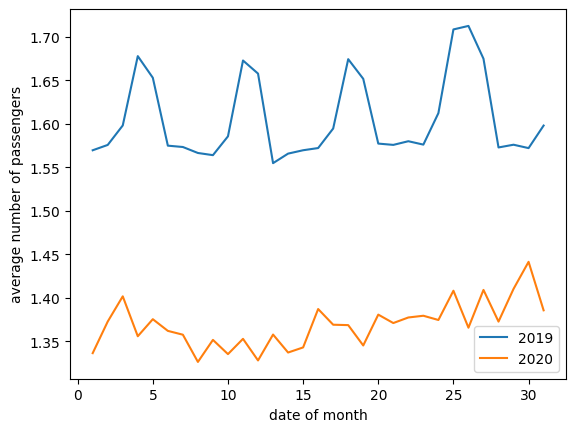

In [53]:
#Question 13: Make a plot looking at average number of passengers differs
plt.plot(rides_daily_2019['day'], rides_daily_2019['mean_pass'], label = 2019)
plt.plot(rides_daily_2020['day'], rides_daily_2020['mean_pass'], label = 2020)
plt.xlabel('date of month')
plt.ylabel('average number of passengers')
plt.legend()
plt.show()

Clearly lots more solo rides!

Are people more or less generous to taxi drivers in a pandemic? Let's look at the percentage of tips

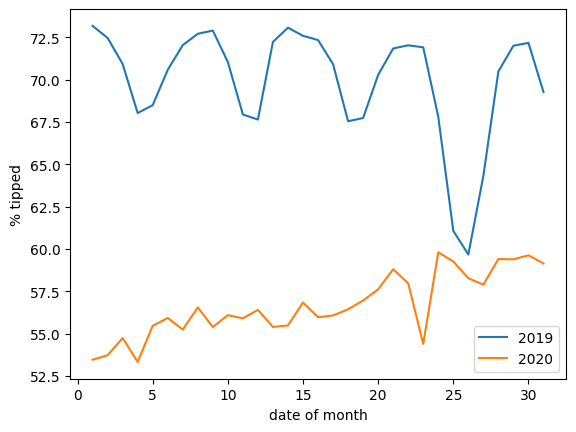

In [54]:
# Make a plot looking at tip percentage over the month with each year as it's own line.
plt.plot(rides_daily_2019['day'], rides_daily_2019['percent_tipped'], label = 2019)
plt.plot(rides_daily_2020['day'], rides_daily_2020['percent_tipped'], label = 2020)
plt.xlabel('date of month')
plt.ylabel('% tipped')
plt.legend()
plt.show()

# Conclusion

This is a pretty big lesson that covers a whole bunch of operations that are used for data cleaning.  You might not need to do all this, or you might need to do more.  As you can see, your first pass through, transforming your data has a lot of back-and-forth as you identify issues. Once you figured them out it would be much easier to streamline and turn into a function (see below).  

Next week we'll get into working with JSON data and strings.    

## Converting to functions
Here I just quicky went and converted the script above into several functions.  I then call in a new dataset and apply them.  

You should **definitely** play around with them and try different filtering options to see how it affects the output. You should see some significant changes in what the data say depending on the choices you make.

**This is an essential point! Choosing the correct input data is the difference between having a reliable output or not**

In [55]:
def drop_na_and_cols(df):
  df = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount']].dropna()
  return(df)

In [56]:
def filter_to_real(df):
  df = df[(df['passenger_count'] >= 1) &
              (df['trip_distance'] >= 0.25) &
              (df['trip_distance'] <= 15) &
              (df['fare_amount'] >= 3) &
              (df['fare_amount'] <= 100) &
              (df['tip_amount'] >= 0) &
              (df['tip_amount'] <= 20) ]
  return(df)

In [61]:
# Note I added start_date and end_date arguments here so you can specify the date range of the data
def make_features(df, start_date, end_date):
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'] )
  df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
  df = df[(df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] <= end_date)]
  df['trip_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
  df['trip_time'] = (df['trip_time']).dt.total_seconds() / 60
  df = df[(df['trip_time'] >= 2) & (df['trip_time'] <= 120)]
  df['trip_speed'] = df['trip_distance']/(df['trip_time']/60)
  df['tip_per_distance'] = df['tip_amount'] / df['trip_distance']
  df = df[(df['trip_speed'] <= 75) & (df['tip_per_distance'] <= 10) ]
  df['tipped'] = np.where(df['tip_amount'] > 0, 1, 0)
  return(df)


In [62]:
def agg_and_rename(df):
  df_daily = df.groupby(df['tpep_pickup_datetime'].dt.date).agg({'passenger_count': ['mean'],
                                                                        'trip_distance': ['mean'],
                                                                        'trip_speed': ['mean'],
                                                                        'tip_amount': ['mean'],
                                                                        'tip_per_distance': ['mean'],
                                                                        'fare_amount':['count'],
                                                                        'tipped': ['sum']})
  df_daily.columns = ['mean_pass', 'mean_dist', 'mean_speed', 'mean_tip', 'mean_tip_dist', 'total_rides', 'number_tipped']
  df_daily['percent_tipped'] = df_daily['number_tipped']/df_daily['total_rides']*100
  return(df_daily)


In [63]:
rides_03_2020 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet")
n_ride = drop_na_and_cols(rides_03_2020)
n_ride = filter_to_real(n_ride)
n_ride = make_features(n_ride, start_date= '2020-03-01 00:00:00', end_date= '2020-03-31 23:59:59')
n_ride = agg_and_rename(n_ride)
n_ride

C:\Users\couga\AppData\Local\Temp\ipykernel_11252\4054023980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
C:\Users\couga\AppData\Local\Temp\ipykernel_11252\4054023980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_time'] = (df['trip_time']).dt.total_seconds() / 60


,mean_pass,mean_dist,mean_speed,mean_tip,mean_tip_dist,total_rides,number_tipped,percent_tipped
tpep_pickup_datetime,,,,,,,,
2020-03-01,1.59,2.61,12.88,1.95,1.03,161111,115841,71.90
2020-03-02,1.49,2.48,11.26,2.08,1.16,175582,130115,74.10
2020-03-03,1.49,2.35,10.12,2.14,1.25,205003,155163,75.69
2020-03-04,1.48,2.39,10.29,2.16,1.23,211218,161112,76.28
2020-03-05,1.49,2.43,10.20,2.20,1.23,224944,172536,76.70
2020-03-06,1.52,2.32,9.70,2.12,1.26,224538,169394,75.44
2020-03-07,1.61,2.38,11.39,1.92,1.10,192043,139401,72.59
2020-03-08,1.58,2.67,13.26,1.94,1.00,149516,107593,71.96
2020-03-09,1.49,2.46,11.34,2.04,1.13,159677,118176,74.01
